In [1]:
import pandas as pd
import numpy as np
import sys
print (sys.version) 

%matplotlib inline
import matplotlib.pyplot as plt   
import statsmodels.api as sm  
import seaborn as sns
sns.set_style('darkgrid')

import random 

import warnings
warnings.filterwarnings("ignore")
sns.set_context('notebook')

3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]


C:\Users\382365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
%%time
# LATEST combined dataset

full_combo_df = pd.read_excel('C:\\Users\\382365\\Documents\\full_combined_data_070517.xlsx')

Wall time: 5min 23s


In [5]:
full_combo_df.dtypes

EMPLOYEE_ID                          int64
EMPLOYEE_NAME                       object
PAYROLL_YEAR                        object
JOB_CLASS                           object
JOB_CLASS_TITLE                     object
DEPT                                 int64
DIV                                float64
PP                                   int64
WORK_DATE                   datetime64[ns]
VAR_CODE                            object
VARIATION_DESCRIPTION               object
TOTALING_GROUP                      object
HOURS                                int64
VAR_RATE                           float64
PAY_AMOUNT                           int64
Claim Number                       float64
DOI                         datetime64[ns]
Time of Inj                 datetime64[ns]
Day of Week                         object
Cd                                 float64
Nature of Injury                    object
Cd.1                               float64
Body Part                           object
Cd.2       

In [6]:
vars_list = full_combo_df['VARIATION_DESCRIPTION'].unique().tolist()

def find_in_list(a_list, a_string):
    return [x for x in a_list if a_string.lower() in str(x).strip().lower()]

descrip_list = find_in_list(vars_list, 'OVERTIME')

OT_list = full_combo_df[full_combo_df['VARIATION_DESCRIPTION'].\
                        isin(descrip_list)]['VAR_CODE'].unique().tolist()

# early, all-embracing OT and regular time (RT) var code choices

OT_var_codes = ['PH', 'PA', 'PB', 'PS', 'PF']
RT_var_codes = ['HW', 'AR', 'TU', 'TD']

important_var_codes = OT_var_codes + RT_var_codes

important_var_codes

['PH', 'PA', 'PB', 'PS', 'PF', 'HW', 'AR', 'TU', 'TD']

In [7]:
# 'safe', approved var code choices
sick_safe = ['SK', 'SS']
vacation_safe = ['VC']
OT_safe = ['PH', 'PA', 'PB']

In [8]:
# Create lists of injured and non-injured employees
# Create dataframes of injured and non-injured employees, taken from the lists

injured_list = full_combo_df[full_combo_df['DOI'].\
                             notnull()]['EMPLOYEE_NAME'].unique().tolist()
not_injured_list = full_combo_df[full_combo_df['DOI'].\
                                 isnull()]['EMPLOYEE_NAME'].unique().tolist()

injured_df = full_combo_df[full_combo_df['EMPLOYEE_NAME'].\
                           isin(injured_list)].reset_index(drop=True)
not_injured_df = full_combo_df[full_combo_df['EMPLOYEE_NAME'].\
                               isin(not_injured_list)].reset_index(drop=True)

In [9]:
# functions to create time series around specific var codes

def clean_for_var_time_mean(df, var_list):
    new_df = df[df['VAR_CODE'].isin(var_list)].reset_index(drop=True)
    new_df = new_df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'HOURS': 'mean'})
    return new_df.asfreq("D", method='bfill')

def clean_for_var_time_total(df, var_list):
    new_df = df[df['VAR_CODE'].isin(var_list)].reset_index(drop=True)
    new_df = new_df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'HOURS': 'sum'})
    return new_df.asfreq("D", method='bfill')


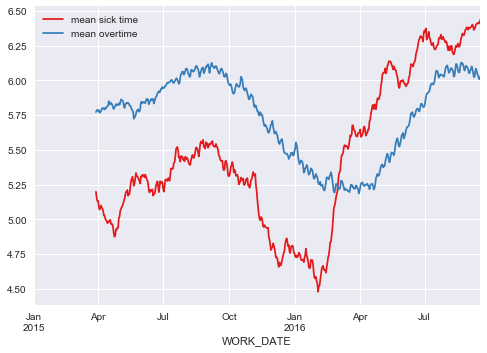

In [10]:
sns.set_palette("Set1")

test_data = full_combo_df
sick_filtered_mean = clean_for_var_time_mean(test_data, sick_safe)
OT_filtered_mean = clean_for_var_time_mean(test_data, OT_safe)
vacation_filtered_mean = clean_for_var_time_mean(test_data, vacation_safe)

fig, ax = plt.subplots()
sick_filtered_mean['2015':'2016'].rolling(88).mean().\
    plot(ax = ax, label = 'sick time')
OT_filtered_mean['2015':'2016'].rolling(88).mean().\
    plot(ax = ax, label = 'overtime')
ax.legend(['mean sick time', 'mean overtime'])

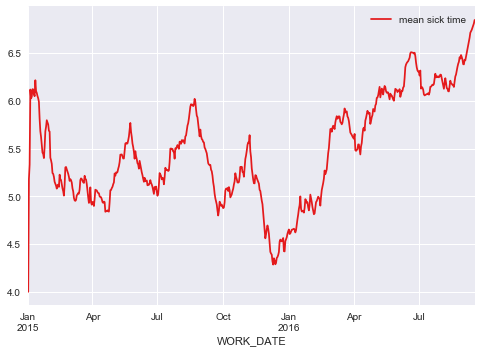

In [11]:
# plot exponentially weighted moving average of mean sick time
sick_filtered_mean['2015':'2016'].ewm(alpha=0.03).mean().plot()
plt.legend(['mean sick time'])

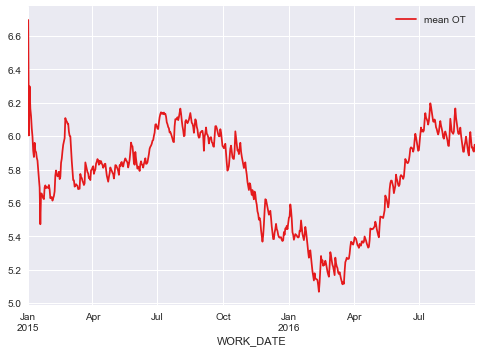

In [12]:
OT_filtered_mean['2015':'2016'].ewm(alpha=0.03).mean().plot()
plt.legend(['mean OT'])

In [13]:
# what job class titles are in the dataset again?

full_combo_df['JOB_CLASS_TITLE'].unique()

array(['TRAF OFFICER II', 'TRAF OFFICER I'], dtype=object)

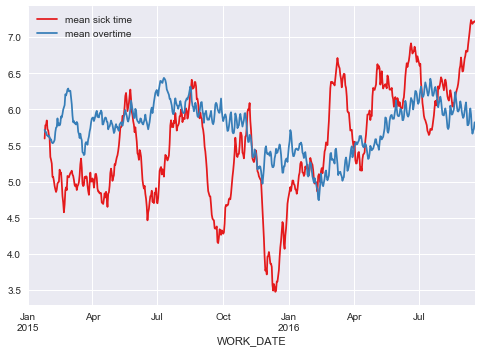

In [14]:
fig, ax = plt.subplots()
sick_filtered_mean['2015':'2016'].rolling(24)\
    .mean().plot(ax = ax, label = 'sick time')
OT_filtered_mean['2015':'2016'].rolling(24)\
    .mean().plot(ax = ax, label = 'overtime')
ax.legend(['mean sick time', 'mean overtime'])

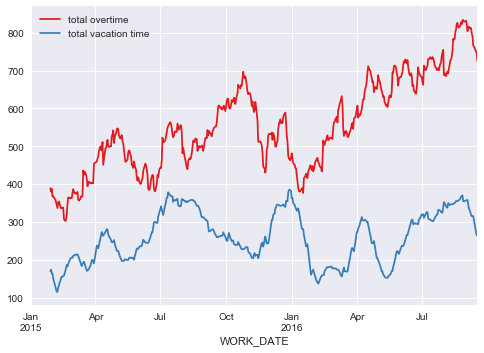

In [15]:
test_data = full_combo_df

sick_filtered_total = clean_for_var_time_total(test_data, 
                                               sick_safe)
OT_filtered_total = clean_for_var_time_total(test_data, 
                                             OT_safe)
vacation_filtered_total = clean_for_var_time_total(test_data, 
                                                   vacation_safe)

fig, ax = plt.subplots()
OT_filtered_total['2015':'2016'].rolling(28).mean().\
    plot(ax = ax, label = 'overtime')
vacation_filtered_total['2015':'2016'].rolling(28).mean().\
    plot(ax = ax, label = 'vacation time')
ax.legend(['total overtime', 'total vacation time'])

In [16]:
# potential injury var codes?  still trying to verify
injury_codes_list = ['IS', 'XA', 'XB', 'XAT', 'XBT', 
                     'LD', 'SJ', 'WC']

# possible workers' compensation var codes
descrip_list = find_in_list(vars_list, 'comp')

Inj_codes = full_combo_df[full_combo_df['VARIATION_DESCRIPTION']\
                          .isin(descrip_list)]['VAR_CODE'].unique().tolist()

In [17]:
# more information on potential injury var codes
full_combo_df[full_combo_df['VAR_CODE'].isin(injury_codes_list)].\
    groupby('VARIATION_DESCRIPTION')['VAR_CODE'].unique()

VARIATION_DESCRIPTION
CURR YR IOD CONVERSION ADJUSTMENT                                      [XA]
LIGHT DUTY RETURN TO WORK PROGRAM                                      [LD]
NET IOD (POS OR NEG)                                                   [IS]
PRIOR YR IOD CONVERSION ADJUSTMENT                                     [XB]
REDUCTION FROM TERMINATION PAYOUTS BAL OWED- CURR YR IOD CONV ADJ     [XAT]
REDUCTION FROM TERMINATION PAYOUTS BAL OWED- PRIOR YR IOD CONV ADJ    [XBT]
SEDENTARY DUTY                                                         [SJ]
WORKERS' COMPENSATION (POS OR NEG)                                     [WC]
Name: VAR_CODE, dtype: object

In [18]:
# what are the possible workers' compensation codes?
Inj_codes

['WC', 'CP']

In [19]:
# more information on potential workers' compensation codes
full_combo_df[full_combo_df['VAR_CODE'].isin(Inj_codes)].\
    groupby('VARIATION_DESCRIPTION')['VAR_CODE'].unique()


VARIATION_DESCRIPTION
CPTO - COMPENSATED PERSONAL TIME OFF    [CP]
WORKERS' COMPENSATION (POS OR NEG)      [WC]
Name: VAR_CODE, dtype: object

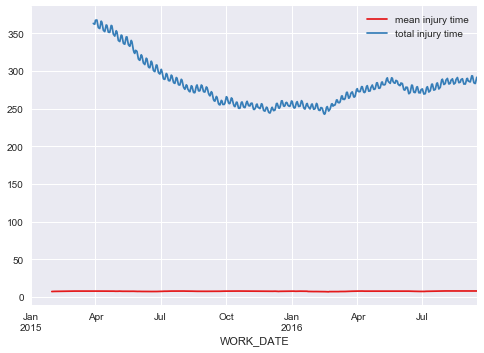

In [20]:
# plot mean and total injury time, using injury_codes_list

IOD_filtered_mean = clean_for_var_time_mean(full_combo_df, injury_codes_list)
IOD_filtered_total = clean_for_var_time_total(full_combo_df, injury_codes_list)

fig, ax = plt.subplots()
IOD_filtered_mean['2015':'2016'].rolling(30).\
    mean().plot(ax = ax, label = 'injury time mean')
IOD_filtered_total['2015':'2016'].rolling(88).\
    mean().plot(ax = ax, label = 'injury time total')
ax.legend(['mean injury time', 'total injury time'])

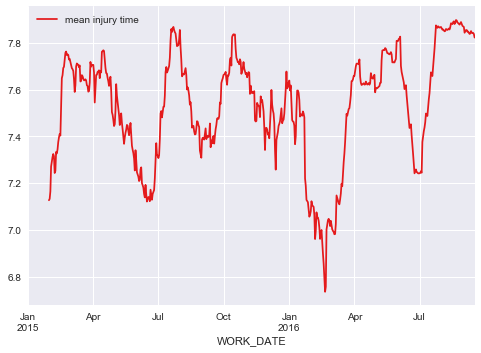

In [21]:
# plot only mean injury time, using injury_codes_list
# it doesn't vary that much
fig, ax = plt.subplots()
IOD_filtered_mean['2015':'2016'].rolling(30)\
    .mean().plot(ax = ax, label = 'injury time mean')
ax.legend(['mean injury time', 'total injury time'])

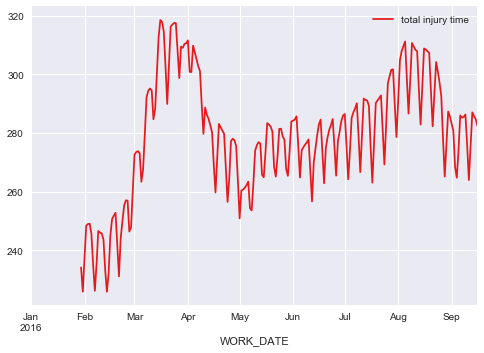

In [22]:
# injury time seems to have a weekly component
fig, ax = plt.subplots()
IOD_filtered_total['2016'].rolling(30).mean()\
    .plot(ax = ax, label = 'injury time total')
ax.legend(['total injury time'])

In [23]:
# sick_filtered_mean = clean_for_var_time_mean(full_combo_df, sick_safe)
# sick_filtered_total = clean_for_var_time_total(full_combo_df, sick_safe)
# OT_filtered_mean = clean_for_var_time_mean(full_combo_df, OT_safe)
# OT_filtered_total = clean_for_var_time_total(full_combo_df, OT_safe)

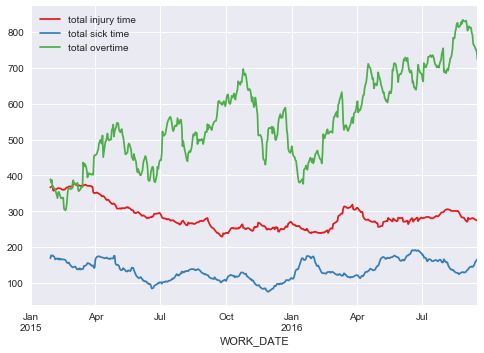

In [24]:
# plot total injury time against total sick time and overtime
fig, ax = plt.subplots()
IOD_filtered_total['2015':'2016'].rolling(28)\
    .mean().plot(ax = ax, label = 'injury time total')
sick_filtered_total['2015':'2016'].rolling(28)\
    .mean().plot(ax = ax, label = 'sick time total')
OT_filtered_total['2015':'2016'].rolling(28)\
    .mean().plot(ax = ax, label = 'OT total')
ax.legend(['total injury time', 'total sick time', 'total overtime'])

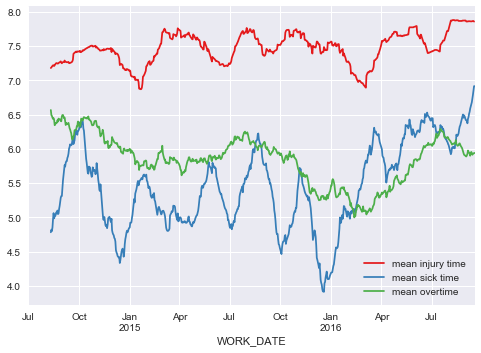

In [25]:
# plot mean injury time against mean sick time and overtime
fig, ax = plt.subplots()
IOD_filtered_mean['July 2014':'2016'].rolling(42)\
    .mean().plot(ax = ax, label = 'mean injury time')
sick_filtered_mean['July 2014':'2016'].rolling(42)\
    .mean().plot(ax = ax, label = 'mean sick time')
OT_filtered_mean['July 2014':'2016'].rolling(42)\
    .mean().plot(ax = ax, label = 'mean OT')
ax.legend(['mean injury time', 'mean sick time', 'mean overtime'])

In [26]:
# functions to create time series of counts

def get_injured_count(df):
    new_df = df[df['DOI'].notnull()].reset_index(drop=True)
    new_df = new_df[new_df['DOI']== new_df['WORK_DATE']]
    new_df = new_df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'EMPLOYEE_NAME': 'nunique'})
    return new_df.asfreq("D", method='bfill')

def clean_for_var_count(df, var_list):
    new_df = df[df['VAR_CODE'].isin(var_list)].reset_index(drop=True)
    new_df = new_df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'EMPLOYEE_NAME': 'nunique'})
    return new_df.asfreq("D", method='bfill')



In [27]:
num_sick_on_day = clean_for_var_count(full_combo_df, 
                                        sick_safe)
num_inj_on_day = clean_for_var_count(full_combo_df, 
                                     injury_codes_list)
num_OT_on_day = clean_for_var_count(full_combo_df, 
                                    OT_safe)

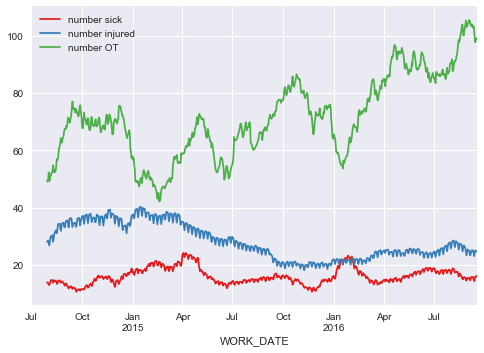

In [28]:
# plot number injured on one day against number sick and number using OT
fig, ax = plt.subplots()
num_sick_on_day['July 2014':'2016'].rolling(30)\
    .mean().plot(ax = ax, label = 'number sick')
num_inj_on_day['July 2014':'2016'].rolling(30)\
    .mean().plot(ax = ax, label = 'number injuries')
num_OT_on_day['July 2014':'2016'].rolling(30)\
    .mean().plot(ax = ax, label = 'number OT')
ax.legend(['number sick', 'number injured', 'number OT'])

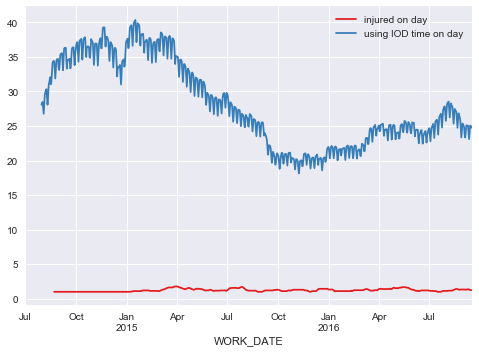

In [29]:
# DOI /using IOD (injured on duty) plot

num_injured_on_day = get_injured_count(full_combo_df)
num_IOD_on_day = clean_for_var_count(full_combo_df, injury_codes_list)

fig, ax = plt.subplots()
num_injured_on_day['July 2014':'2016']\
    .rolling(30).mean().plot(ax = ax, label = 'number injured on day')
num_IOD_on_day['July 2014':'2016']\
    .rolling(30).mean().plot(ax = ax, label = 'number using IOD on day')
ax.legend(['injured on day', 'using IOD time on day'])


In [30]:
# days with the most injuries
num_injured_on_day.sort_values(by = 'EMPLOYEE_NAME', 
                               ascending = False).head(40)

,EMPLOYEE_NAME
WORK_DATE,
2016-01-13,4
2015-07-03,3
2015-12-13,3
2016-03-23,3
2016-03-30,3
2016-03-31,3
2016-04-25,3
2016-04-26,3
2016-05-05,3


In [31]:
# “outlier values” plot

def get_outlier_count(df, var_list):
    new_df = df[df['VAR_CODE'].isin(var_list)].reset_index(drop=True)
    new_df = new_df[new_df['HOURS']> new_df['HOURS'].mean()+ new_df['HOURS'].std()]
    new_df = new_df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'EMPLOYEE_NAME': 'nunique'})
    return new_df.asfreq("D", method='bfill')

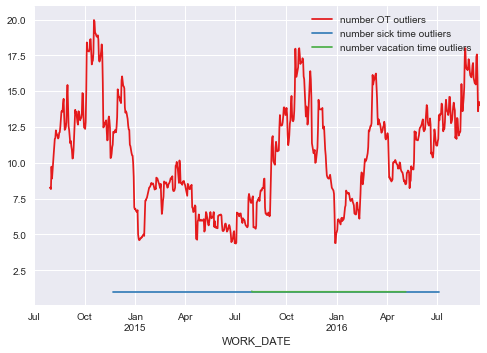

In [32]:
# plot OT, sick, vacation time outliers
num_OT_outliers_on_day = get_outlier_count(full_combo_df, 
                                           OT_safe)
num_sick_outliers_on_day = get_outlier_count(full_combo_df, 
                                             sick_safe)
num_VC_outliers_on_day = get_outlier_count(full_combo_df, 
                                           vacation_safe)

fig, ax = plt.subplots()
num_OT_outliers_on_day['July 2014':'2016']\
    .rolling(30).mean().plot(ax = ax)
num_sick_outliers_on_day['July 2014':'2016']\
    .rolling(30).mean().plot(ax = ax)
num_VC_outliers_on_day['July 2014':'2016']\
    .rolling(30).mean().plot(ax = ax)
ax.legend(['number OT outliers', 
           'number sick time outliers', 'number vacation time outliers'])

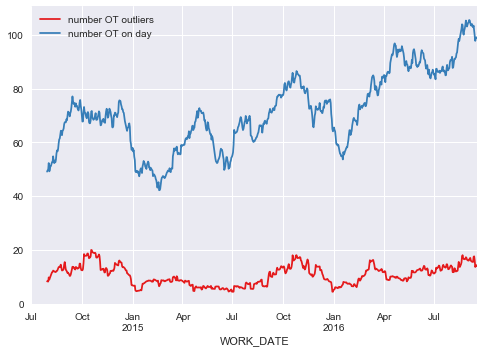

In [33]:
# plot OT outliers/number OT on day
fig, ax = plt.subplots()
num_OT_outliers_on_day['July 2014':'2016']\
    .rolling(30).mean().plot(ax = ax,  label = 'number OT outliers')
num_OT_on_day['July 2014':'2016']\
    .rolling(30).mean().plot(ax = ax, label = 'number OT on day')
ax.legend(['number OT outliers', 'number OT on day'])

In [34]:
# days with most people using injury time
clean_for_var_count(full_combo_df, 
                    injury_codes_list)\
    .sort_values(by = 'EMPLOYEE_NAME', ascending = False).head(30)

,EMPLOYEE_NAME
WORK_DATE,
2014-11-13,59
2014-11-12,58
2014-11-14,57
2014-12-22,53
2014-11-07,53
2015-01-14,53
2014-10-08,53
2014-12-19,53
2015-02-04,53


In [35]:
# number of employees with specific number of injuries
full_combo_df.groupby('Total Number of Injuries')['EMPLOYEE_NAME'].nunique()

Total Number of Injuries
0    490
1    173
2     52
3     15
4      3
5      2
7      1
Name: EMPLOYEE_NAME, dtype: int64

In [36]:
# change 'Emp Knowledge Dt' (Employer Knowledge Date) to datetime
full_combo_df['Emp Knowledge Dt'] = pd.to_datetime(full_combo_df['Emp Knowledge Dt'])

In [37]:
full_combo_df.groupby(['Emp Knowledge Dt', 'DOI', 'EMPLOYEE_NAME'])\
    ['EMPLOYEE_NAME'].nunique().sort_values(ascending = False)

Emp Knowledge Dt  DOI         EMPLOYEE_NAME                 
2016-12-28        2016-12-28  PETITT, ISANG                     1
2015-09-10        2015-09-08  MCCORRY, BRANDI                   1
2015-08-10        2015-07-24  WHITE, ALVA GWENDOLYN             1
2015-08-13        2015-08-12  FREEMAN, LASKER                   1
2015-08-21        2015-08-21  RENDER, ROBIN RENEE               1
2015-08-26        2015-08-26  MCCORRY PHILLIPS, SHAUN DENISE    1
2015-08-31        2015-08-22  PEDRAZA, ALFREDO                  1
2015-09-02        2015-09-02  BROWN, DWIGHT K                   1
2015-09-09        2015-09-08  BROWN, DUANE V                    1
2015-09-10        2015-06-16  RODRICKS, TRACY A                 1
                  2015-09-10  CRAIG, CHERYL RENEE               1
2015-08-04        2015-08-04  HALL, ANGELA LEE                  1
2015-09-14        2015-09-14  RAGGETT, LENICIA ANITA            1
2015-09-15        2015-07-27  BONNER, NICHOLE L                 1
2015-09-21     

In [38]:
# create new temporary column, showing the difference between employee-reported date of injury ('DOI') 
# and employer/boss notified reported date ('Emp Knowledge Dt')

full_combo_df['EKD_DOI_diff']  = (full_combo_df['Emp Knowledge Dt'] 
                                  - full_combo_df['DOI']).dt.days

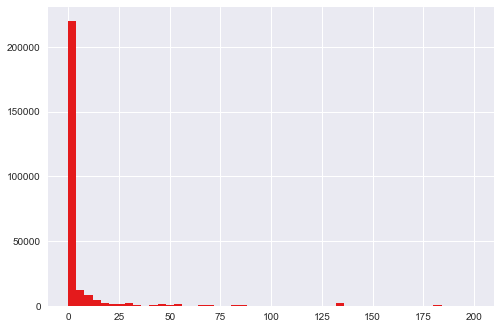

In [39]:
# histogram of the differences between DOI and Emp Knowledge Dt
full_combo_df['EKD_DOI_diff'].hist(bins = 50, range=[0, 200])

In [40]:
# what do the injuries for employees with more than 100 day lags 
# between DOI and Emp Knowledge Dt look like?
# final column is lag value

full_combo_df[full_combo_df['EKD_DOI_diff']>100].\
    groupby(['EMPLOYEE_NAME', 'Total Number of Injuries', 'Claim Cause', 'Contrib Cause'])\
    ['EKD_DOI_diff'].agg({'Lag': 'mean'}).sort_values(by='Lag', ascending = False)

,,,,Lag
EMPLOYEE_NAME,Total Number of Injuries,Claim Cause,Contrib Cause,
"JACKSON, TAWNY FRANCES",2,"Cumulative, NOC",Repetitive work,1158.0
"HATCH, CYNTHIA ELAINE",1,"Cumulative, NOC",Repetitive work,760.0
"WHITE, ALVA GWENDOLYN",3,Repetitive Motion - Other,Unsafe work condition/act,376.0
"DAVID, EMMANUEL LOPEZ",1,"Cumulative, NOC",Repetitive work,315.0
"ACOSTA, GABRIEL ALEX",5,"Cumulative, NOC",Repetitive work,288.0
"COOPER, NORMA F",1,"Cumulative, NOC",Equipment use (unsafe or lack of),274.0
"BROWN, DWIGHT K",2,Repetitive Motion - Other,Equipment use (unsafe or lack of),241.0
"BRENNER, LARRY R",1,Repetitive Motion - Other,Repetitive work,223.0
"HARSHAW, NANETTE",4,"Dust, Gases, Fumes or",Unsafe work condition/act,220.0


In [41]:
# youngest and oldest people in dataset?
full_combo_df['Years Old on Workdate'].min(), 
full_combo_df['Years Old on Workdate'].max()

82.9945205479452

In [42]:
# create a dataframe with only DOI
test_df = full_combo_df[full_combo_df['WORK_DATE']== full_combo_df['DOI']]

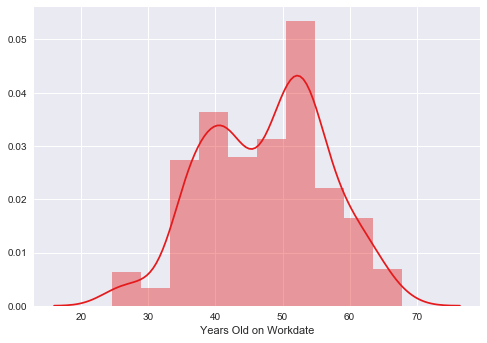

In [43]:
sns.distplot(test_df['Years Old on Workdate'], bins = 10)

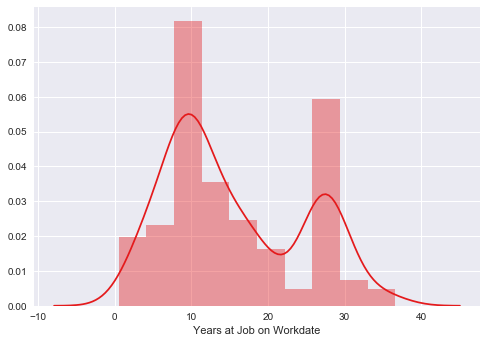

In [44]:
sns.distplot(test_df['Years at Job on Workdate'], bins = 10)

In [45]:
bins = np.arange(20, 90, 3)
new_test = test_df.groupby(pd.cut(test_df['Years Old on Workdate'], 
                                  bins))['Total Number of Injuries']\
    .mean()

new_test.fillna(0, inplace=True)


In [46]:
# What are the bins with highest average number of injuries?
new_test.sort_values(ascending = False)

Years Old on Workdate
(35, 38]    2.622222
(38, 41]    2.000000
(53, 56]    1.934426
(32, 35]    1.900000
(56, 59]    1.840000
(41, 44]    1.809524
(59, 62]    1.809524
(50, 53]    1.807692
(23, 26]    1.800000
(62, 65]    1.705882
(47, 50]    1.666667
(29, 32]    1.600000
(44, 47]    1.266667
(26, 29]    1.166667
(65, 68]    1.000000
(86, 89]    0.000000
(83, 86]    0.000000
(68, 71]    0.000000
(71, 74]    0.000000
(74, 77]    0.000000
(77, 80]    0.000000
(80, 83]    0.000000
(20, 23]    0.000000
Name: Total Number of Injuries, dtype: float64

In [47]:
safe_var_codes = sick_safe + OT_safe + vacation_safe

In [48]:
# find the outlier values for each var code-- mean, +/- 1 standard deviation

base_values_df = full_combo_df[full_combo_df['VAR_CODE'].isin(safe_var_codes)].\
    groupby(['VAR_CODE', 'VARIATION_DESCRIPTION'])['HOURS']\
    .agg({'mean': np.mean, 'upper bound': lambda x: (np.mean(x)+np.std(x)),
          'lower bound': lambda x: (np.mean(x)-np.std(x)),})\
    .sort_values(by = 'upper bound', ascending = False).head(40)

base_values_df = base_values_df.reset_index()

base_values_df.columns

Index(['VAR_CODE', 'VARIATION_DESCRIPTION', 'mean', 'lower bound',
       'upper bound'],
      dtype='object')

In [49]:
base_values_df

,VAR_CODE,VARIATION_DESCRIPTION,mean,lower bound,upper bound
0,SK,100% SICK TIME (CREDIT OR CHARGE),5.091475,-0.799657,10.982608
1,SS,75% SICK TIME (CREDIT OR CHARGE),4.912899,-1.079088,10.904887
2,VC,VACATION (POS AND NEG),6.726483,3.088905,10.364060
3,PA,OVERTIME (1.5) WORKED AND PAID,6.026974,3.024466,9.029482
4,PB,OVERTIME (1.0) WORKED AND PAID,3.434884,-0.217983,7.087750
5,PH,PAID OVERTIME (HOLIDAY 1.5),2.000000,2.000000,2.000000


In [50]:
safe_val_df = full_combo_df[full_combo_df['VAR_CODE']\
                            .isin(safe_var_codes)].reset_index(drop = True)

In [51]:
good_df = pd.merge(safe_val_df, base_values_df, on='VAR_CODE')


In [52]:
high_use_df = good_df[good_df['HOURS']>good_df['upper bound']]

In [53]:
low_use_df =  good_df[good_df['HOURS']<good_df['lower bound']]

In [54]:
# what are the days with OT above the upper bound?
high_use_df[high_use_df['VAR_CODE'].isin(OT_safe)]\
    .groupby('WORK_DATE')['EMPLOYEE_NAME']\
    .nunique().sort_values(ascending= False).head(50)

WORK_DATE
2014-10-05    108
2015-10-18     98
2014-10-18     75
2016-08-14     73
2014-10-04     72
2015-03-22     70
2014-11-30     68
2014-07-04     68
2016-08-20     68
2016-05-21     67
2015-07-04     66
2015-11-29     63
2015-07-25     63
2016-07-04     63
2016-09-10     63
2014-12-07     58
2015-08-09     55
2014-08-30     54
2016-03-06     52
2016-08-13     51
2015-09-19     50
2015-03-15     50
2016-02-14     49
2015-09-05     49
2014-08-02     49
2015-11-07     48
2016-08-06     48
2014-09-27     48
2014-11-13     47
2014-08-03     43
2015-11-28     43
2015-04-24     43
2015-01-19     43
2015-10-17     42
2015-09-12     41
2014-07-26     41
2016-04-12     41
2015-10-24     39
2016-01-18     38
2015-02-22     38
2016-05-15     38
2014-10-11     37
2016-02-28     37
2016-07-16     37
2015-10-03     35
2015-10-10     35
2014-11-29     35
2016-07-23     35
2014-07-27     34
2016-06-12     34
Name: EMPLOYEE_NAME, dtype: int64

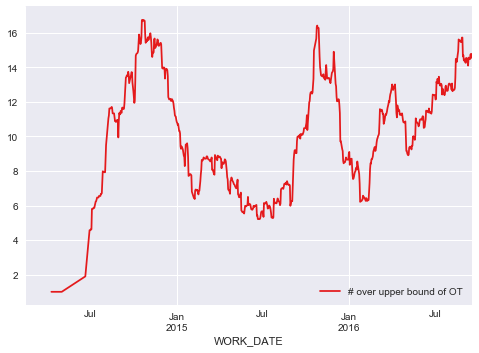

In [55]:
# create and plot a dataframe of high use days (number of people over upper bound)
high_use_days = high_use_df[high_use_df['VAR_CODE']\
                            .isin(OT_safe)].groupby('WORK_DATE')['EMPLOYEE_NAME']\
    .nunique()['2011':'2016'].asfreq("D", method='bfill')

high_use_days['2014':'2016'].rolling(56).mean().plot()
plt.legend(['# over upper bound of OT'])

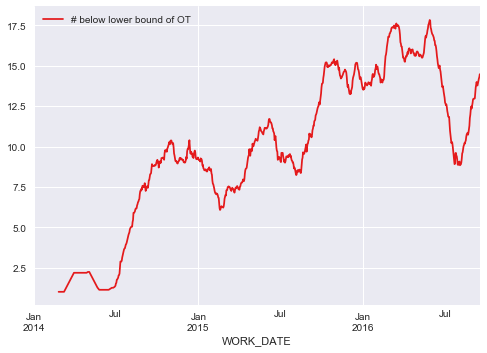

In [56]:
# create and plot a dataframe of low use days (number of people below lower bound)
low_use_days = low_use_df[low_use_df['VAR_CODE'].isin(OT_safe)]\
    .groupby('WORK_DATE')['EMPLOYEE_NAME'].nunique()['2011':'2016']\
    .asfreq("D", method='bfill')

low_use_days['2014':'2016'].rolling(56).mean().plot()
plt.legend(['# below lower bound of OT'])

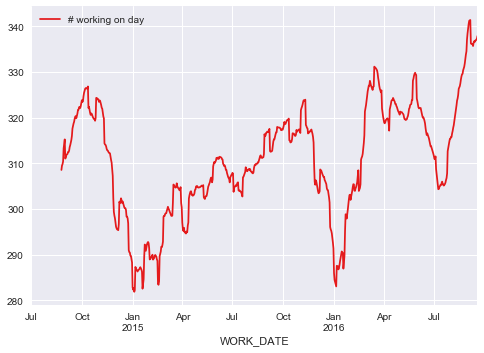

In [57]:
# create and plot a dataframe of number of people working on day (using either OT or RT)
num_working_df= full_combo_df.groupby('WORK_DATE')['EMPLOYEE_NAME'].nunique()

num_working_group = full_combo_df[full_combo_df['VAR_CODE']\
                                  .isin(important_var_codes)]\
    .groupby('WORK_DATE')['EMPLOYEE_NAME'].nunique()['2011':'2016'].asfreq("D", method='bfill')

num_working_group['7 2014':'2016'].rolling(56).mean().plot()
plt.legend(['# working on day'])

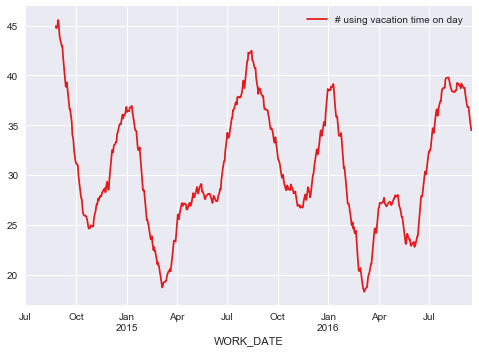

In [58]:
# create and plot a dataframe of number of people using vacation time on day
num_vacationing_group = full_combo_df[full_combo_df['VAR_CODE'].isin(['VC'])]\
    .groupby('WORK_DATE')['EMPLOYEE_NAME'].nunique()['2011':'2016']\
    .asfreq("D", method='bfill')

num_vacationing_group['7 2014':'2016'].rolling(56).mean().plot()
plt.legend(['# using vacation time on day'])

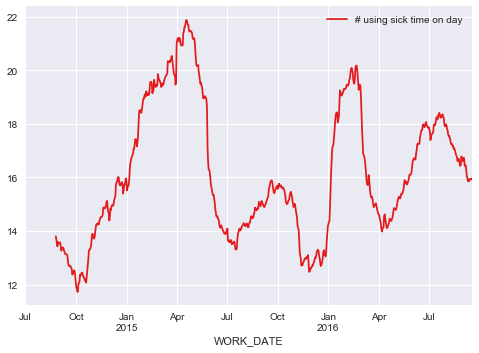

In [59]:
# create and plot a dataframe of number of people using sick time on day
num_sick_group = full_combo_df[full_combo_df['VAR_CODE'].isin(sick_safe)]\
    .groupby('WORK_DATE')['EMPLOYEE_NAME'].nunique()['2011':'2016']\
    .asfreq("D", method='bfill')

num_sick_group['7 2014':'2016'].rolling(56).mean().plot()
plt.legend(['# using sick time on day'])

In [60]:
# get the mean of the moving average for prior datasets 
# (number of people working OT, vacation, sick time), 
# so they can all be put on the same graph
work_ave = np.mean(num_working_group['7 2014':'2016'].rolling(42).mean())
vac_ave = np.mean(num_vacationing_group['7 2014':'2016'].rolling(42).mean())
sick_ave = np.mean(num_sick_group['7 2014':'2016'].rolling(42).mean())
print([work_ave, vac_ave, sick_ave])

[311.03932132020526, 30.866895783020624, 16.116849340516445]


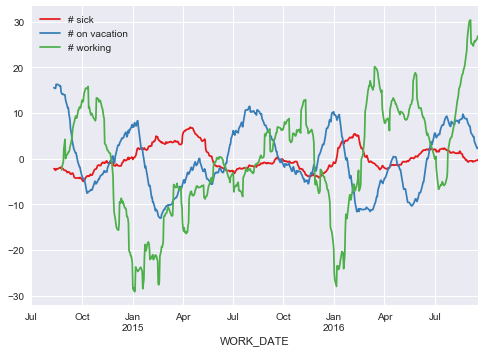

In [61]:
# plot number emploees using sick time, OT, vacation time minus each respective one's mean, so they can be put on one graph
# and their shapes can be compared

fig, ax = plt.subplots()
(num_sick_group-sick_ave)['7 2014':'2016']\
    .rolling(42).mean().plot(ax = ax, label = 'number of workers using sick time')
(num_vacationing_group-vac_ave)['7 2014':'2016']\
    .rolling(42).mean().plot(ax = ax, label = 'number of workers using vacation time')
(num_working_group-work_ave)['7 2014':'2016']\
    .rolling(56).mean().plot(ax = ax, label = 'number of workers working')
ax.legend(['# sick', '# on vacation', "# working"])

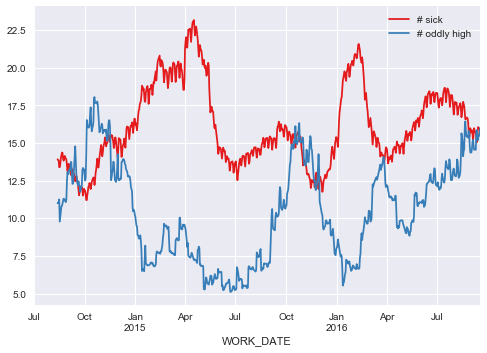

In [62]:
# plot number sick versus number in 'high use' (above upper bound) category
fig, ax = plt.subplots()
(num_sick_group)['7 2014':'2016'].rolling(44)\
    .mean().plot(ax = ax, label = 'number of workers using sick time')
(high_use_days)['7 2014':'2016'].rolling(44)\
    .mean().plot(ax = ax, label = 'number of workers with oddly high')

ax.legend(['# sick', '# oddly high', "# oddly low"])

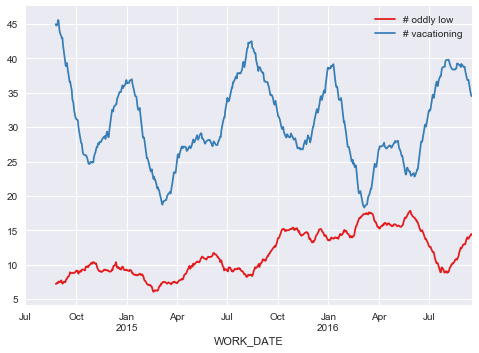

In [63]:
# plot number vacation versus number in 'low use' (below upper bound) category
fig, ax = plt.subplots()
(low_use_days)['7 2014':'2016'].rolling(56).mean()\
    .plot(ax = ax, label = 'number of workers with oddly low')
(num_vacationing_group)['7 2014':'2016'].rolling(56)\
    .mean().plot(ax = ax, label = 'number of workers using vacation time')
ax.legend(['# oddly low', '# vacationing'])

In [64]:
# how many times do "important var codes" appear in the dataset?
full_combo_df[full_combo_df['VAR_CODE'].isin(important_var_codes)].\
    groupby(['VAR_CODE', 'VARIATION_DESCRIPTION'])['VARIATION_DESCRIPTION'].count().\
    sort_values(ascending = False)

VAR_CODE  VARIATION_DESCRIPTION                 
HW        CURRENT ACTUAL HOURS WORKED ONLY          269507
PA        OVERTIME (1.5) WORKED AND PAID             73440
AR        ADJUSTMENT PERMANENT VARIATION IN RATE     12819
TU        TEMPORARY VARIATION IN RATE - UP            4114
PB        OVERTIME (1.0) WORKED AND PAID               430
PH        PAID OVERTIME (HOLIDAY 1.5)                    1
Name: VARIATION_DESCRIPTION, dtype: int64